[*********************100%***********************]  1 of 1 completed


Training LSTM Pure...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Training LSTM with CNN...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Training LSTM with GA...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms

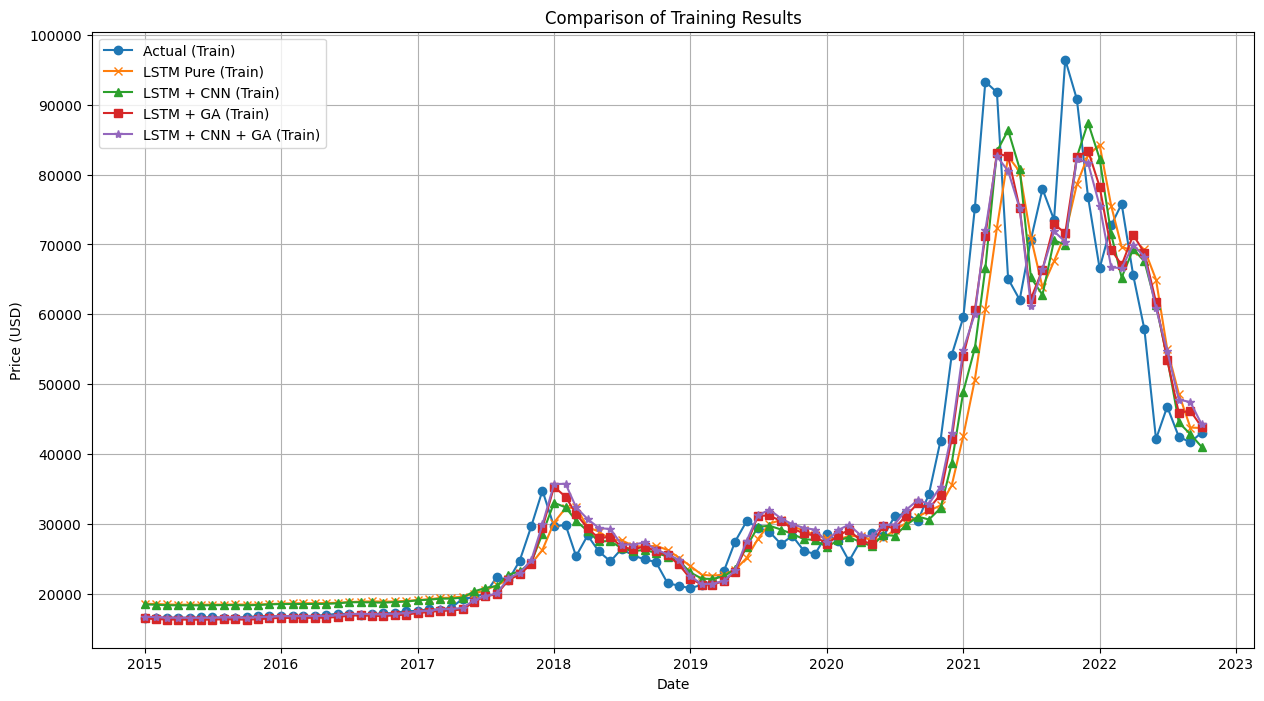

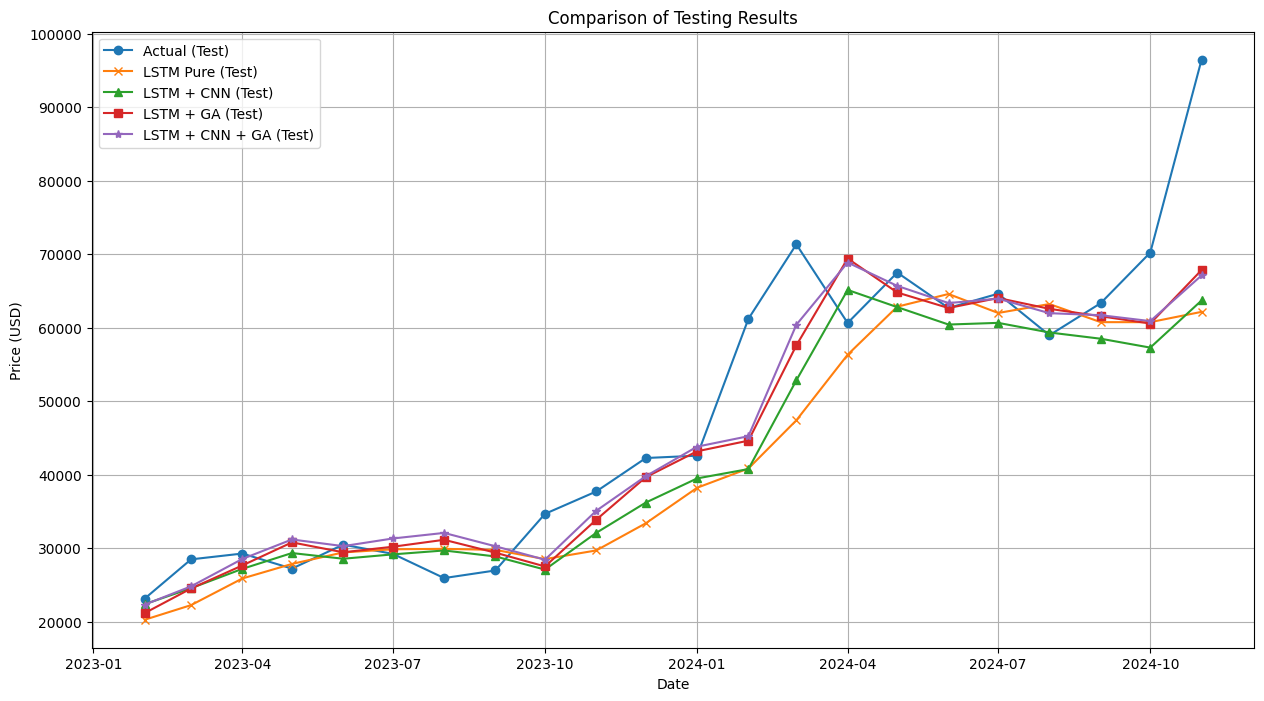


=== Evaluation Metrics ===
LSTM Pure - MAE: 7152.624911221591, MSE: 118765973.17130193, RMSE: 10897.980233570896
LSTM + CNN - MAE: 6551.506214488636, MSE: 103085831.58584942, RMSE: 10153.119303241217
LSTM + GA - MAE: 5498.868519176137, MSE: 73591616.36935128, RMSE: 8578.555610902764
LSTM + CNN + GA - MAE: 5229.979758522727, MSE: 70129298.39031912, RMSE: 8374.323757194912


In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import set_random_seed
import random
import math

# Konfigurasi GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:  # Changed gps to gpus
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


set_random_seed(42)
np.random.seed(42)
random.seed(42)

class GeneticAlgorithmOptimizer:
    def __init__(self, population_size, generations, mutation_rate):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate

    def create_population(self):
        return [
            {
                'units': random.randint(32, 128),
                'learning_rate': random.uniform(0.0001, 0.01),
                'batch_size': random.choice([16, 32, 64])
            }
            for _ in range(self.population_size)
        ]

    def mutate(self, individual):
        if random.random() < self.mutation_rate:
            individual['units'] = random.randint(32, 128)
        if random.random() < self.mutation_rate:
            individual['learning_rate'] = random.uniform(0.0001, 0.01)
        if random.random() < self.mutation_rate:
            individual['batch_size'] = random.choice([16, 32, 64])
        return individual

    def crossover(self, parent1, parent2):
        child = {
            'units': parent1['units'] if random.random() < 0.5 else parent2['units'],
            'learning_rate': parent1['learning_rate'] if random.random() < 0.5 else parent2['learning_rate'],
            'batch_size': parent1['batch_size'] if random.random() < 0.5 else parent2['batch_size']
        }
        return self.mutate(child)

    def select_best(self, population, scores, n_best=3):
        sorted_population = [x for _, x in sorted(zip(scores, population))]
        return sorted_population[:n_best]

    def optimize(self, train_data, train_target, val_data, val_target, time_steps):
        population = self.create_population()
        best_model = None
        best_score = float('inf')

        for generation in range(self.generations):
            scores = []
            for individual in population:
                model = Sequential([
                    Input(shape=(time_steps, 1)),
                    Conv1D(filters=individual['units'] // 2, kernel_size=2, activation='relu'),
                    MaxPooling1D(pool_size=2),
                    LSTM(individual['units']),
                    Dense(1)
                ])
                model.compile(optimizer=Adam(learning_rate=individual['learning_rate']), loss='mse')
                model.fit(train_data, train_target, epochs=10, batch_size=individual['batch_size'], verbose=0)
                val_predict = model.predict(val_data)
                score = mean_squared_error(val_target, val_predict)
                scores.append(score)

                if score < best_score:
                    best_score = score
                    best_model = model

            best_individuals = self.select_best(population, scores)
            new_population = best_individuals
            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(best_individuals, 2)
                new_population.append(self.crossover(parent1, parent2))
            population = new_population

        return best_model

class BitcoinPredictor:
    def __init__(self, start_date='2014-01-01', end_date='2024-12-01'):
        self.start_date = start_date
        self.end_date = end_date
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    def fetch_bitcoin_data(self):
        btc = yf.download('BTC-USD', start=self.start_date, end=self.end_date, interval='1mo')
        return btc[['Close']]

    def prepare_dataset(self, data, time_steps=3):
        scaled_data = self.scaler.fit_transform(data.values.reshape(-1, 1))
        X, Y = [], []
        for i in range(len(scaled_data) - time_steps):
            X.append(scaled_data[i:(i + time_steps), 0])
            Y.append(scaled_data[i + time_steps, 0])
        return (np.array(X).reshape(-1, time_steps, 1), np.array(Y).reshape(-1, 1))

    def calculate_metrics(self, actual, predicted):
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        rmse = math.sqrt(mse)
        return mae, mse, rmse

    def train_lstm_pure(self, X_train, y_train, X_test, y_test, time_steps):
        model_lstm = Sequential([
            Input(shape=(time_steps, 1)),
            LSTM(64),
            Dense(1)
        ])
        model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
        train_predict_lstm = model_lstm.predict(X_train)
        test_predict_lstm = model_lstm.predict(X_test)
        return model_lstm, train_predict_lstm, test_predict_lstm

    def train_and_compare(self, time_steps=3, test_size=0.2):
        data = self.fetch_bitcoin_data()
        data['Date'] = data.index
        data = data.reset_index(drop=True)

        train_size = int(len(data) * (1 - test_size))
        train_data, test_data = data[:train_size], data[train_size:]

        X_train, y_train = self.prepare_dataset(train_data['Close'], time_steps)
        X_test, y_test = self.prepare_dataset(test_data['Close'], time_steps)

        # Training LSTM Pure
        print("Training LSTM Pure...")
        model_lstm, train_pred_lstm, test_pred_lstm = self.train_lstm_pure(X_train, y_train, X_test, y_test, time_steps)
        train_pred_lstm = self.scaler.inverse_transform(train_pred_lstm)
        test_pred_lstm = self.scaler.inverse_transform(test_pred_lstm)

        # Training LSTM with CNN
        print("Training LSTM with CNN...")
        model_cnn_lstm = Sequential([
            Input(shape=(time_steps, 1)),
            Conv1D(filters=32, kernel_size=2, activation='relu'),
            MaxPooling1D(pool_size=2),
            LSTM(64),
            Dense(1)
        ])
        model_cnn_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        model_cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
        train_pred_cnn_lstm = model_cnn_lstm.predict(X_train)
        test_pred_cnn_lstm = model_cnn_lstm.predict(X_test)
        train_pred_cnn_lstm = self.scaler.inverse_transform(train_pred_cnn_lstm)
        test_pred_cnn_lstm = self.scaler.inverse_transform(test_pred_cnn_lstm)

        # Training LSTM with GA
        print("Training LSTM with GA...")
        ga_optimizer = GeneticAlgorithmOptimizer(population_size=10, generations=10, mutation_rate=0.2)
        model_lstm_ga = ga_optimizer.optimize(X_train, y_train, X_test, y_test, time_steps)
        train_pred_lstm_ga = model_lstm_ga.predict(X_train)
        test_pred_lstm_ga = model_lstm_ga.predict(X_test)
        train_pred_lstm_ga = self.scaler.inverse_transform(train_pred_lstm_ga)
        test_pred_lstm_ga = self.scaler.inverse_transform(test_pred_lstm_ga)

        # Training LSTM with CNN + GA
        print("Training LSTM with CNN + GA...")
        model_cnn_lstm_ga = ga_optimizer.optimize(X_train, y_train, X_test, y_test, time_steps)
        train_pred_cnn_lstm_ga = model_cnn_lstm_ga.predict(X_train)
        test_pred_cnn_lstm_ga = model_cnn_lstm_ga.predict(X_test)
        train_pred_cnn_lstm_ga = self.scaler.inverse_transform(train_pred_cnn_lstm_ga)
        test_pred_cnn_lstm_ga = self.scaler.inverse_transform(test_pred_cnn_lstm_ga)

        actual_test = self.scaler.inverse_transform(y_test)
        actual_train = self.scaler.inverse_transform(y_train)
        metrics = {
            "LSTM Pure": self.calculate_metrics(actual_test, test_pred_lstm),
            "LSTM + CNN": self.calculate_metrics(actual_test, test_pred_cnn_lstm),
            "LSTM + GA": self.calculate_metrics(actual_test, test_pred_lstm_ga),
            "LSTM + CNN + GA": self.calculate_metrics(actual_test, test_pred_cnn_lstm_ga)
        }

        for method, (mae, mse, rmse) in metrics.items():
            print(f"\n=== {method} ===")
            print(f"Testing MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

        # Plot Training Results
        plt.figure(figsize=(15, 8))
        plt.plot(train_data['Date'][time_steps:], actual_train, label='Actual (Train)', marker='o')
        plt.plot(train_data['Date'][time_steps:], train_pred_lstm, label='LSTM Pure (Train)', marker='x')
        plt.plot(train_data['Date'][time_steps:], train_pred_cnn_lstm, label='LSTM + CNN (Train)', marker='^')
        plt.plot(train_data['Date'][time_steps:], train_pred_lstm_ga, label='LSTM + GA (Train)', marker='s')
        plt.plot(train_data['Date'][time_steps:], train_pred_cnn_lstm_ga, label='LSTM + CNN + GA (Train)', marker='*')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.title('Comparison of Training Results')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot Testing Results
        plt.figure(figsize=(15, 8))
        plt.plot(test_data['Date'][time_steps:], actual_test, label='Actual (Test)', marker='o')
        plt.plot(test_data['Date'][time_steps:], test_pred_lstm, label='LSTM Pure (Test)', marker='x')
        plt.plot(test_data['Date'][time_steps:], test_pred_cnn_lstm, label='LSTM + CNN (Test)', marker='^')
        plt.plot(test_data['Date'][time_steps:], test_pred_lstm_ga, label='LSTM + GA (Test)', marker='s')
        plt.plot(test_data['Date'][time_steps:], test_pred_cnn_lstm_ga, label='LSTM + CNN + GA (Test)', marker='*')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.title('Comparison of Testing Results')
        plt.legend()
        plt.grid(True)
        plt.show()

        return metrics


def main():
    predictor = BitcoinPredictor()
    metrics = predictor.train_and_compare()
    print("\n=== Evaluation Metrics ===")
    for method, (mae, mse, rmse) in metrics.items():
        print(f"{method} - MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

if __name__ == "__main__":
    main()
